# 简介

COVID-19，全称：Corona Virus Disease 2019，中文名称：2019冠状病毒病，于2019年12月第一次大面积、迅速爆发，在2020年3月11日，世界卫生组织（WHO）宣布COVID-19为全球大流行病，距离上次甲型H1N1流感被宣布为全球大流行病，仅有11年。三个月内，COVID-19席卷全球，七个月内，COVID-19从各方面对人类造成了严重的损失，时至今日，在影响力较强的国家中，也只有中国将感染人数控制在了50以下，西方大国尤其美国仍深受其困。而目前并没有针对COVID-19的治疗特效药，而且已经被感染的人群仍然有比较高的感染率，在这种情况下，通过对比COVID-19与其他大流行传染病的相关数据，我们能否发现些许曙光？

# 1.COVID-19

## 准备工作

### 安装包

In [ ]:
!pip install pycountry_convert 
!pip install folium
!pip install keras
!pip install plotly
!pip install folium
!pip install branca

### 导入包

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

%matplotlib inline

Using TensorFlow backend.


### 准备数据

- 注意，如果下方提取数据的代码报错显示“远程主机强迫关闭连接”，请稍等几分钟再尝试

#### 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([LINK](https://github.com/CSSEGISandData/COVID-19)) 

In [60]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

URLError: <urlopen error [WinError 10061] 由于目标计算机积极拒绝，无法连接。>

In [ ]:
#统一表格标题命名
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [70]:
#根据pycountry_convert Lib的要求更改国家名称 
#USA
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
#South 
df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# 函数 获取国家和大陆数据
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

In [71]:
df_table = df_table[df_table["continent"] != "Others"] #其他地区数据

In [72]:
#缺项数据处理
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

### 函数框架

In [73]:
#曲线图的绘制
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # 设置精度和刻度
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # 设置网格精度
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # 图表标题
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Y轴
    plt.yscale(scale)
    plt.minorticks_on()
    # X轴Y轴标签
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
#可视化
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # 子图
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
    #在图中标出具体数值    
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
#获取数据
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]

#获取数据
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)

#日期
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


## 数据分析并可视化

### 获取数据

In [74]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)
df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

### 全球疫情现状

In [75]:
pd.DataFrame(df_countries_cases.sum()).transpose().style.background_gradient(cmap='Wistia',axis=1)

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID
0,6979789.000000,401848.000000,3130301.000000,3407562.000000,27443.985089,0.000000,0.000000,655.316799,97529.000000


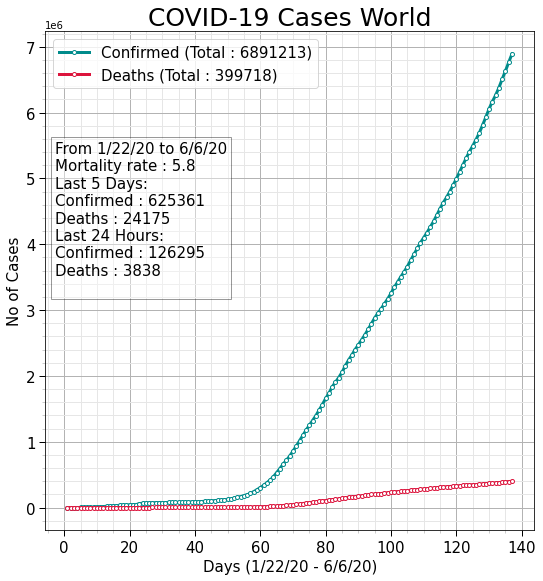

In [76]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))
visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])
plt.show()

### 各大洲情况

In [77]:
df_continents_cases.style.background_gradient(cmap='Wistia')

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID
continent,,,,,,,,,
Africa,189294.000000,5176.000000,82845.000000,101273.000000,1651.045179,0.000000,0.000000,132.372730,24764
Asia,1360408.000000,35017.000000,821565.000000,503826.000000,7794.094651,0.000000,0.000000,94.258228,18454
Australia,8790.000000,124.000000,8210.000000,456.000000,61.801873,0.000000,0.000000,2.867725,1430
Europe,2084790.000000,178887.000000,1027329.000000,838503.000000,12246.429070,0.000000,0.000000,244.994469,18538
North America,2209155.000000,133492.000000,670691.000000,1404972.000000,1945.591464,0.000000,0.000000,99.237218,8292
Others,2622.000000,55.000000,2123.000000,437.000000,1559.418040,0.000000,0.000000,40.901078,21343
South America,1124730.000000,49097.000000,517538.000000,558095.000000,2185.604812,0.000000,0.000000,40.685351,4708


### 各国情况

In [79]:
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')

C:\Users\lishuyuan\AppData\Roaming\Python\Python37\site-packages\pandas\io\formats\style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
C:\Users\lishuyuan\AppData\Roaming\Python\Python37\site-packages\pandas\io\formats\style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


#### TOP 10 

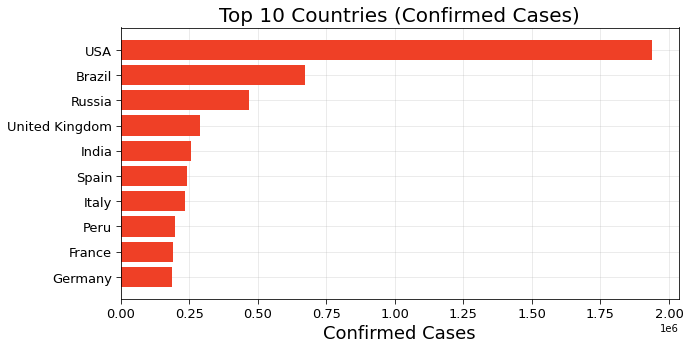

In [80]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color='#EF4026')
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

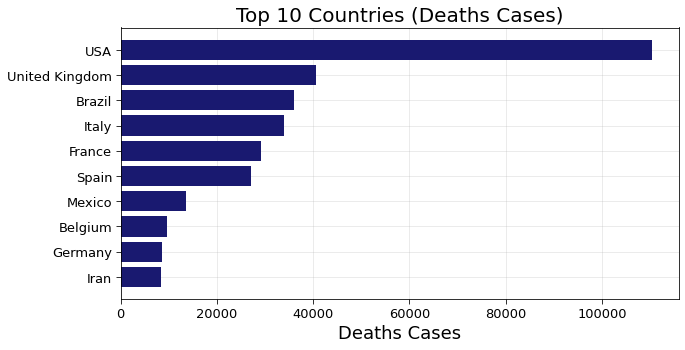

In [81]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="midnightblue")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

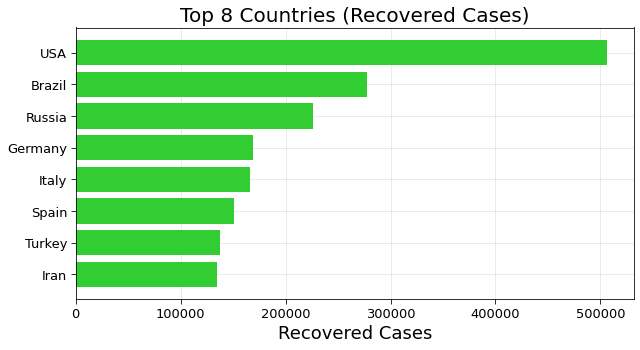

In [86]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 8 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')

## COVID-19患者年龄组成

数据来源

[https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

[https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data](https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv(r'COVID19_open_line_list.csv')

#### 清洗数据，删除不需要的列，整理三类状态

In [ ]:
data.drop(['Unnamed: '+str(x) for x in range(33,45)],axis=1,inplace=True) 
data.head()
def clean(x):
    if x == 'death' or x == 'died' or x == 'Death':
        return 'death'
    elif x == 'discharged' or x=='discharge':
        return 'discharge'
    elif x == 'recovered' or x=='stable':
        return 'recovered'
    else:
        return np.nan

#### 确保age为整数

In [ ]:
#设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

#### 查看年龄组成

In [ ]:
plt.figure(figsize=(14,5), dpi=100)
sns.distplot(data[data['outcome'].apply(clean)=='death']['age'].apply(apply_int),hist=False,rug=True,label='死亡')
sns.distplot(data[data['outcome'].apply(clean)=='discharge']['age'].apply(apply_int),hist=False,rug=True,label='出院')
sns.distplot(data[data['outcome'].apply(clean)=='recovered']['age'].apply(apply_int),hist=False,rug=True,label='恢复')

plt.xlabel('年龄',size=20)
plt.ylabel('比例',size=20)
plt.title('COVID19对各年龄的影响',size=25)
plt.grid(linestyle='--',alpha=0.5)
plt.legend()

plt.show()

# 其他传染病

以下数据来源于中国疾控中心官方网站

# 2.甲型H1N1

## 年龄组成

In [49]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [50]:
df = pd.read_csv('H1N1_age.csv')
df

,age,Cases,Death,发病数,发病数.1,发病数.2,发病数.3,发病数.4,Death.1,死亡数,死亡数.1,死亡数.2,死亡数.3
0,0,1765,25,882,24,134,340,385,17,6,1,0,1
1,1,1991,23,850,48,171,467,455,18,2,2,1,0
2,2,2538,18,1317,42,207,429,543,9,7,0,0,2
3,3,3367,20,1971,68,239,533,556,11,4,3,1,1
4,4,3286,13,2141,73,217,393,462,10,2,0,0,1
5,5,3775,8,2736,68,193,323,455,7,1,0,0,0
6,6,4605,5,3669,64,163,286,423,4,0,0,0,1
7,7,5617,9,4733,63,141,185,495,8,1,0,0,0
8,8,6153,7,5440,47,122,151,393,5,2,0,0,0
9,9,6850,9,6220,18,108,131,373,7,2,0,0,0


<Figure size 3000x2000 with 0 Axes>

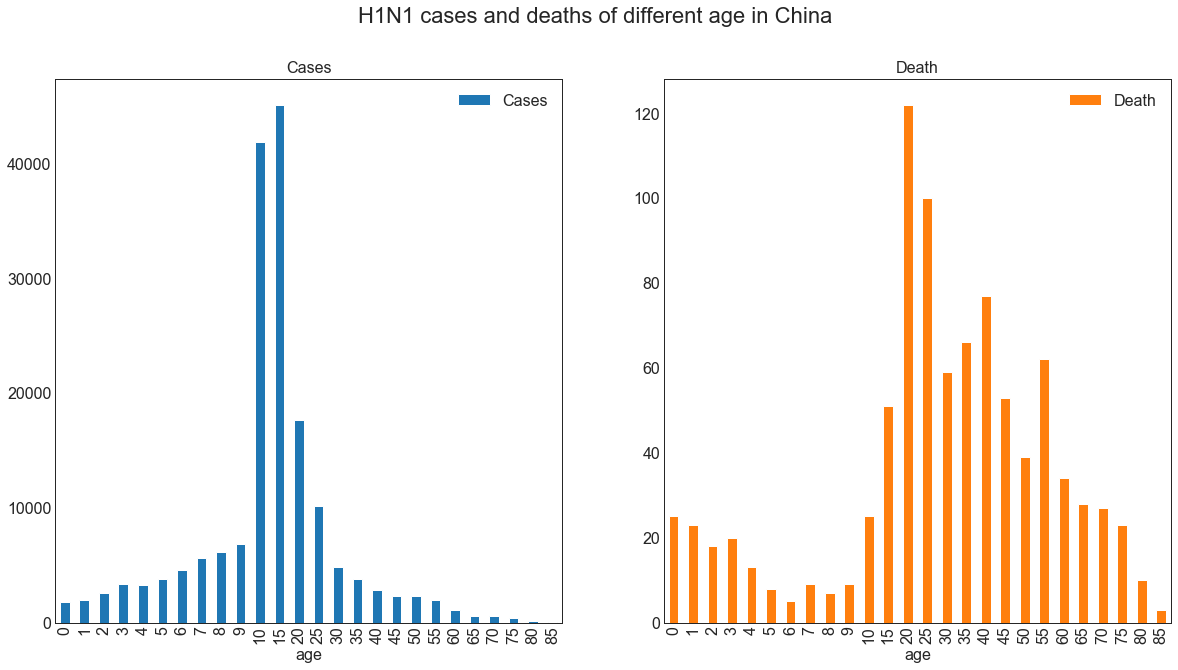

In [51]:
plt.figure(dpi=500)
df.plot(x='age',
       y=['Cases','Death'],
       kind ='bar',
       subplots = True,
       layout=(1,2),
       figsize=(20,10),
       title='H1N1 cases and deaths of different age in China')
plt.show()

In [53]:
df = pd.read_csv('H1N1_time.csv')
df

,month,num
0,1,0
1,2,0
2,3,0
3,4,0
4,5,37
5,6,638
6,7,968
7,8,1945
8,9,20026
9,10,36476


<Figure size 3000x2000 with 0 Axes>

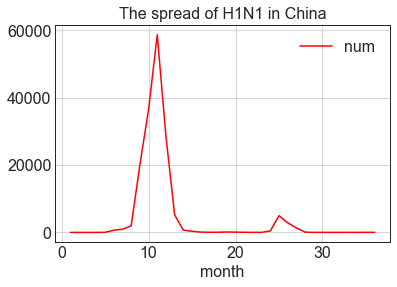

In [54]:
plt.figure(dpi=500)
df.plot(x='month',
       y='num',
       kind='line',
       color='red',
       grid=True,
       title='The spread of H1N1 in China')
plt.show()

# 3.传染性肝炎

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [68]:
df = pd.read_csv('ganyan_age.csv')
df

,age,cases,death
0,0.0,7224.0,2.0
1,1.0,3206.0,2.0
2,2.0,3392.0,1.0
3,3.0,3826.0,0.0
4,4.0,3381.0,0.0
5,5.0,2881.0,2.0
6,6.0,2506.0,0.0
7,7.0,2014.0,1.0
8,8.0,1845.0,0.0
9,9.0,1866.0,0.0


<Figure size 3000x2000 with 0 Axes>

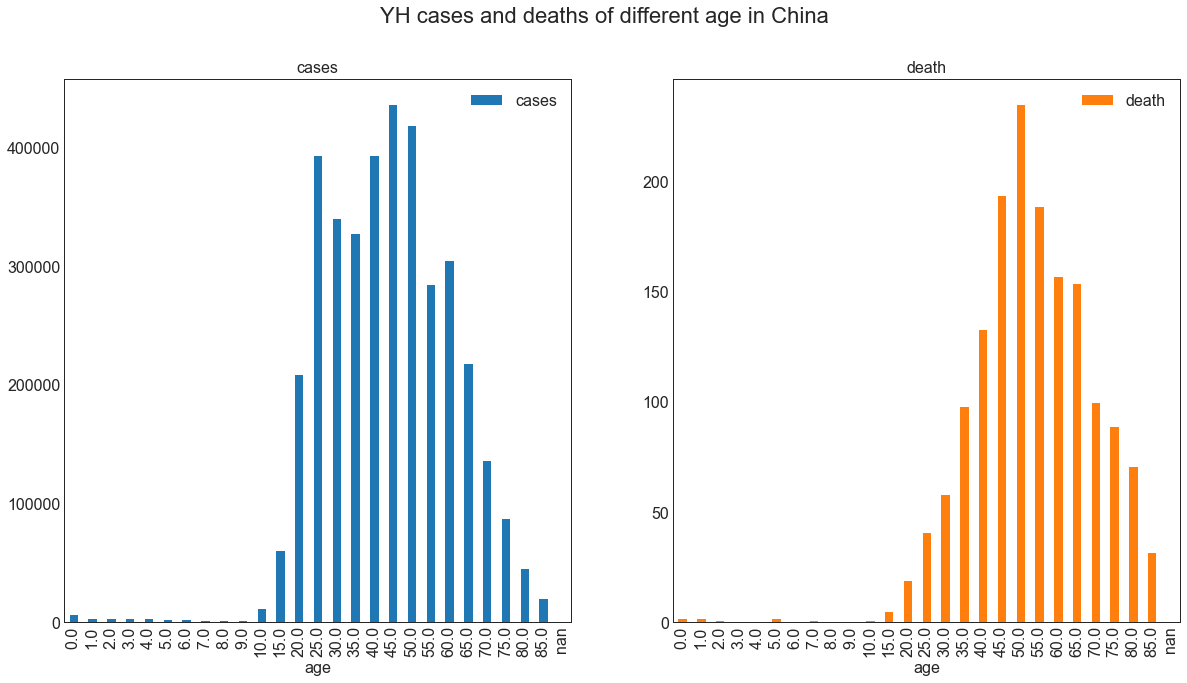

In [69]:
plt.figure(dpi=500)
df.plot(x='age',
       y=['cases','death'],
       kind ='bar',
       subplots = True,
       layout=(1,2),
       figsize=(20,10),
       title='YH cases and deaths of different age in China')
plt.show()

In [66]:
df = pd.read_csv('ganyan_time_year.csv')
df

,date,num
0,2004,1152874
1,2005,1195355
2,2006,1334859
3,2007,1425428
4,2008,1407664
5,2009,1425020
6,2010,1317982
7,2011,1372344
8,2012,1380800
9,2013,1251872


<Figure size 3000x2000 with 0 Axes>

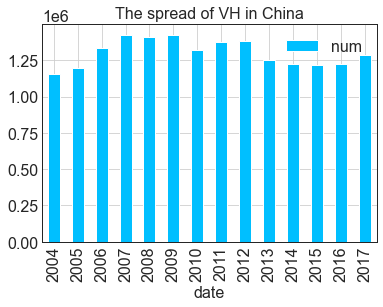

In [67]:
plt.figure(dpi=500)
df.plot(x='date',
       y='num',
       kind='bar',
       color='deepskyblue',
       grid=True,
       title='The spread of VH in China')
plt.show()

In [62]:
df = pd.read_csv('ganyan_time_season.csv')
df

,month,num
0,1,112516
1,2,127920
2,3,137104
3,4,129110
4,5,124063
5,6,124594
6,7,128786
7,8,124342
8,9,107946
9,10,108578


<Figure size 3000x2000 with 0 Axes>

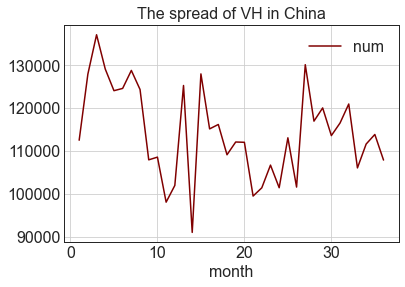

In [65]:
plt.figure(dpi=500)
df.plot(x='month',
       y='num',
       kind='line',
       color='maroon',
       grid=True,
       title='The spread of VH in China')
plt.show()